In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from concurrent.futures import ThreadPoolExecutor

# from utils.methods_RLRW import (
#     runif_ball, 
#     euclid_distance, 
#     weighted_quantile, 
#     smoothed_weighted_quantile, 
#     opt_RLCP_h, 
#     RLCP
# )

from utils.plot_utils import regression_plot_with_uncertainty
from utils.Prediction_bands import (
    split_conformal_bands,
    weighted_conformal_prediction
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)


from scipy.stats import multivariate_normal, norm

In [ ]:
path_baselin_school_csv = "../Data/data_indonesia/school_baseline.csv" 
path_students_baseline_csv = "../Data/data_indonesia/students_baseline.csv"
path_teachers_baseline_csv = "../Data/data_indonesia/teachers_baseline.csv"
path_students_extra = "../Data/data_indonesia/students_EXTRA.csv"
path_students = "../Data/data_indonesia/students.csv"
path_teachers = "../Data/data_indonesia/teachers.csv"



df_school = pd.read_csv(path_baselin_school_csv)
df_students_baseline = pd.read_csv(path_students_baseline_csv)
df_teachers_baseline = pd.read_csv(path_teachers_baseline_csv)
df_students_extra = pd.read_csv(path_students_extra)
df_students = pd.read_csv(path_students)
df_teachers = pd.read_csv(path_teachers, converters={"treatment": lambda x: int(x == "treatment")})

In [ ]:
df_school.head(10)

,school_id,district_id,triplet_id,year,treatment,SD,nrrombel,nrstudents,classsize,nrteachers
0,178,10,60,0,control,primary school,6,166,27.666666,6
1,172,10,58,0,treatment,primary school,6,212,35.333332,6
2,179,10,60,0,control,primary school,6,132,22.000000,10
3,173,10,58,0,control,primary school,6,33,5.500000,5
4,175,10,59,0,control,primary school,6,105,17.500000,9
5,180,10,60,0,treatment,primary school,6,146,24.333334,6
6,169,10,57,0,treatment,primary school,6,101,16.833334,2
7,174,10,58,0,control,primary school,6,75,12.500000,3
8,170,10,57,0,control,primary school,6,109,18.166666,8
9,171,10,57,0,control,primary school,6,136,22.666666,6


In [ ]:
df_students_baseline.head(10)

,student_id,school_id,district_id,triplet_id,year,treatment,SD,MAT_score,IPA_score,BIN_score,BIG_score,assets
0,62267,166,10,56,0,control,junior secondary school,0.772727,0.863636,0.818182,0.75,0.142857
1,62254,166,10,56,0,control,junior secondary school,0.727273,0.818182,0.863636,0.85,0.285714
2,62284,166,10,56,0,control,junior secondary school,0.681818,0.818182,0.863636,0.80,0.285714
3,62256,166,10,56,0,control,junior secondary school,0.727273,0.818182,0.818182,0.85,0.142857
4,62288,166,10,56,0,control,junior secondary school,0.772727,0.818182,0.818182,0.80,0.142857
5,62249,166,10,56,0,control,junior secondary school,0.636364,0.772727,0.909091,0.70,0.142857
6,62274,166,10,56,0,control,junior secondary school,0.681818,0.818182,0.863636,0.85,0.571429
7,62248,166,10,56,0,control,junior secondary school,0.772727,0.818182,0.863636,0.80,0.142857
8,62282,166,10,56,0,control,junior secondary school,0.681818,0.727273,0.909091,0.80,0.142857
9,62273,166,10,56,0,control,junior secondary school,NaN,0.681818,NaN,0.35,0.142857


<Axes: >

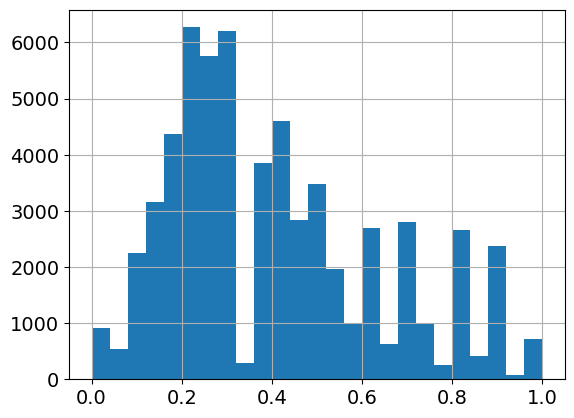

In [ ]:
df_students_baseline["MAT_score"].hist(bins = 25)

In [ ]:
df_students.head(10)

,student_id,school_id,district_id,triplet_id,subject,year,treatment,SD,ITT_score,testbook,ITT_score0,missing_ITT_score0,schoolscore0,missing_schoolscore0,assets,weight,int_mTARGET,int_sTARGET,int_assets,int_N,int_relativesize,int_logN,int_logrelativesize,int_schoolscore0,teacherage,TARGET,T2,NT2,M2,T3,NT3,M3,P2,P3
0,63708,178,10,60,IPA,2,control,primary school,-1.939628,1,0.0,1,0.0,1,0.428571,0.333333,0.285714,2,0.661017,59,0.091615,4.077538,-2.390161,NaN,53.0,1.0,1.0,0.0,0,0.0,0.0,1,0.0,NaN
1,63708,178,10,60,MAT,2,control,primary school,-2.314207,1,0.0,1,0.0,1,0.428571,0.333333,0.285714,2,0.661017,59,0.091615,4.077538,-2.390161,NaN,53.0,1.0,1.0,0.0,0,0.0,0.0,1,0.0,NaN
2,63708,178,10,60,BIN,2,control,primary school,-2.362830,1,0.0,1,0.0,1,0.428571,0.333333,0.285714,2,0.661017,59,0.091615,4.077538,-2.390161,NaN,53.0,1.0,1.0,0.0,0,0.0,0.0,1,0.0,NaN
3,63711,178,10,60,BIN,2,control,primary school,-0.977294,1,0.0,1,0.0,1,0.000000,0.333333,0.285714,2,0.661017,59,0.091615,4.077538,-2.390161,NaN,53.0,1.0,1.0,0.0,0,0.0,0.0,1,0.0,NaN
4,63711,178,10,60,MAT,2,control,primary school,-1.056875,1,0.0,1,0.0,1,0.000000,0.333333,0.285714,2,0.661017,59,0.091615,4.077538,-2.390161,NaN,53.0,1.0,1.0,0.0,0,0.0,0.0,1,0.0,NaN
5,63711,178,10,60,IPA,2,control,primary school,-1.750918,1,0.0,1,0.0,1,0.000000,0.333333,0.285714,2,0.661017,59,0.091615,4.077538,-2.390161,NaN,53.0,1.0,1.0,0.0,0,0.0,0.0,1,0.0,NaN
6,63710,178,10,60,MAT,2,control,primary school,-1.475986,1,0.0,1,0.0,1,0.428571,0.333333,0.285714,2,0.661017,59,0.091615,4.077538,-2.390161,NaN,53.0,1.0,1.0,0.0,0,0.0,0.0,1,0.0,NaN
7,63710,178,10,60,IPA,2,control,primary school,-1.939628,1,0.0,1,0.0,1,0.428571,0.333333,0.285714,2,0.661017,59,0.091615,4.077538,-2.390161,NaN,53.0,1.0,1.0,0.0,0,0.0,0.0,1,0.0,NaN
8,63710,178,10,60,BIN,2,control,primary school,-1.808615,1,0.0,1,0.0,1,0.428571,0.333333,0.285714,2,0.661017,59,0.091615,4.077538,-2.390161,NaN,53.0,1.0,1.0,0.0,0,0.0,0.0,1,0.0,NaN
9,63722,178,10,60,MAT,2,control,primary school,-0.847319,1,0.0,1,0.0,1,0.571429,0.333333,0.285714,2,0.661017,59,0.091615,4.077538,-2.390161,NaN,53.0,1.0,1.0,0.0,0,0.0,0.0,1,0.0,NaN


In [ ]:
df_school.describe()

,school_id,district_id,triplet_id,year,nrrombel,nrstudents,classsize,nrteachers
count,360.000000,360.000000,360.000000,360.0,360.000000,360.000000,360.000000,360.000000
mean,180.500000,10.500000,60.500000,0.0,8.511111,186.611111,20.860223,9.166667
std,104.067286,5.774307,34.688025,0.0,4.622808,134.662164,7.020421,4.796122
min,1.000000,1.000000,1.000000,0.0,3.000000,17.000000,2.833333,2.000000
25%,90.750000,5.750000,30.750000,0.0,6.000000,96.000000,15.964285,6.000000
50%,180.500000,10.500000,60.500000,0.0,6.000000,148.500000,21.416667,7.000000
75%,270.250000,15.250000,90.250000,0.0,9.250000,218.000000,25.407143,11.000000
max,360.000000,20.000000,120.000000,0.0,30.000000,820.000000,40.833332,37.000000


In [ ]:
df_students.describe()

,student_id,school_id,district_id,triplet_id,year,ITT_score,testbook,ITT_score0,missing_ITT_score0,schoolscore0,missing_schoolscore0,assets,weight,int_mTARGET,int_sTARGET,int_assets,int_N,int_relativesize,int_logN,int_logrelativesize,int_schoolscore0,teacherage,TARGET,T2,NT2,M2,T3,NT3,M3,P2,P3
count,554059.000000,554059.000000,554059.000000,554059.000000,554059.000000,554059.000000,554059.000000,5.540590e+05,554059.000000,554059.000000,554059.000000,515849.000000,554059.000000,554059.000000,554059.000000,554059.000000,554059.000000,554059.000000,554059.000000,554059.000000,545761.000000,519463.000000,520103.000000,554059.000000,554059.000000,554059.000000,554059.000000,554059.000000,554059.000000,528585.000000,434622.000000
mean,67797.279187,180.114459,10.594556,60.382642,2.496324,0.010357,6.125091,-3.163093e-09,0.711863,0.196715,0.014977,0.584736,0.284422,0.514926,7.843876,3.706333,288.057321,0.394534,5.445894,-1.124395,0.199706,43.319784,0.541198,0.441488,0.498230,0.060282,0.417210,0.376158,0.206631,0.334733,0.506302
std,39412.135892,103.162420,5.727714,34.389017,0.499987,1.008643,2.524397,5.367426e-01,0.452896,1.038222,0.121460,0.223157,0.041032,0.199394,5.359916,1.005783,177.740128,0.228941,0.702838,0.668543,1.045799,8.759010,0.482147,0.486883,0.490383,0.238010,0.477627,0.468663,0.404889,0.463185,0.488375
min,1.000000,1.000000,1.000000,1.000000,2.000000,-4.471739,1.000000,-3.651184e+00,0.000000,-2.347267,0.000000,0.000000,0.250000,0.000000,0.000000,0.375000,10.000000,0.013038,2.302585,-4.339901,-2.347267,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32815.000000,93.000000,6.000000,31.000000,2.000000,-0.716269,4.000000,0.000000e+00,0.000000,-0.557704,0.000000,0.428571,0.250000,0.384615,4.000000,3.042857,144.000000,0.218944,4.969813,-1.518939,-0.568128,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68853.000000,189.000000,11.000000,63.000000,2.000000,-0.038949,7.000000,0.000000e+00,1.000000,0.022628,0.000000,0.571429,0.250000,0.500000,6.000000,3.802198,240.000000,0.343168,5.480639,-1.069536,0.041917,45.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,102087.000000,272.000000,16.000000,91.000000,3.000000,0.721456,8.000000,0.000000e+00,1.000000,0.821458,0.000000,0.714286,0.333333,0.652174,11.000000,4.268344,409.000000,0.555901,6.013715,-0.587166,0.832197,50.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,135558.000000,360.000000,20.000000,120.000000,3.000000,5.325746,9.000000,4.861450e+00,1.000000,5.226312,1.000000,1.000000,0.333333,1.000000,27.000000,6.283019,767.000000,1.000000,6.642487,0.000000,5.226312,61.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_teachers.describe()

,teacher_id,school_id,district_id,triplet_id,year,treatment,PAID,TARGET,NOTELIGIBLE,ngscore,pursue,secondjobhours,base_pay,additional_pay,certification_pay,totalpay,absent,quota_year
count,10725.000000,10725.000000,10725.000000,10725.000000,10725.000000,10725.000000,9482.000000,9951.000000,9990.000000,8930.000000,6069.000000,9102.000000,8781.000000,9236.000000,9180.000000,8728.000000,9170.000000,4895.000000
mean,2213.851375,178.968112,10.456783,59.994312,1.688392,0.340886,0.315123,0.522963,0.242442,0.004346,0.168232,2.884311,2.157033,0.638291,0.662232,3.503709,0.167503,2008.987947
std,1276.744611,103.662594,5.757819,34.554732,1.206434,0.474029,0.464589,0.499498,0.428582,1.007677,0.374103,7.185972,0.890092,0.603690,1.048851,1.959299,0.373444,1.400587
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.778343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2006.000000
25%,1098.000000,91.000000,6.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.710631,0.000000,0.000000,1.811700,0.339560,0.000000,2.381948,0.000000,2008.000000
50%,2255.000000,184.000000,11.000000,62.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.022399,0.000000,0.000000,2.431000,0.602300,0.000000,3.257046,0.000000,2009.000000
75%,3324.000000,269.000000,15.000000,90.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.752209,0.000000,2.000000,2.744400,0.889784,1.786530,5.086958,0.000000,2010.000000
max,4393.000000,360.000000,20.000000,120.000000,3.000000,1.000000,1.000000,1.000000,1.000000,3.408105,1.000000,90.000000,4.147870,9.584104,8.729150,15.173103,1.000000,2012.000000


In [ ]:
student_df = df_students_baseline.copy()

In [ ]:
df_teachers.head(5)

,teacher_id,school_id,district_id,triplet_id,year,tested,interviewed,treatment,SD,quota,certified,PAID,TARGET,NOTELIGIBLE,ngscore,S1,pursue,secondjob,secondjobhours,base_pay,additional_pay,certification_pay,totalpay,problems,happy,absent,quota_year
0,2170,178,10,60,2,tested,interviewed,0,primary school,not in quota,not certified,0.0,1.0,0.0,-0.875381,no bachelor's degree,0.0,no second job,0.0,2.7528,1.563500,0.0,4.316300,yes,yes,0.0,NaN
1,2167,178,10,60,2,tested,interviewed,0,primary school,not in quota,not certified,0.0,1.0,0.0,-1.699128,no bachelor's degree,0.0,no second job,0.0,2.4732,1.926659,0.0,4.399859,yes,yes,0.0,NaN
2,2168,178,10,60,2,tested,interviewed,0,primary school,not in quota,not certified,0.0,0.0,1.0,-0.710631,NaN,1.0,second job,6.0,1.5774,1.788169,0.0,3.365569,no,yes,0.0,NaN
3,2169,178,10,60,2,not tested,not interviewed,0,primary school,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2173,178,10,60,2,tested,interviewed,0,primary school,not in quota,not certified,0.0,0.0,1.0,-1.204880,no bachelor's degree,0.0,no second job,0.0,2.2445,1.922563,0.0,4.167063,yes,yes,0.0,NaN


In [ ]:
df_teachers["treatment"].value_counts()

treatment
0    7069
1    3656
Name: count, dtype: int64

In [ ]:
student_df["teacher_average_base_pay"] = student_df["school_id"].map(df_teachers.groupby("school_id")["base_pay"].mean())
student_df["classize"] = student_df["school_id"].map(df_school.groupby("school_id")["classsize"].mean())
student_df["num_teachers"] = student_df["school_id"].map(df_teachers.groupby("school_id")["teacher_id"].count())
student_df["num_students"] = student_df["school_id"].map(df_students_baseline.groupby("school_id")["student_id"].count())
student_df["school_score"]  = student_df["school_id"].map(df_students.groupby("school_id")["schoolscore0"].mean())
student_df["SD"] = np.where(student_df["SD"] == "primary_school", 0, 1)
# student_df["num_treatment"] = student_df["school_id"].map(df_teachers.groupby("school_id")["treatment"].sum())

student_df = student_df.drop(columns = "BIG_score")
student_df = student_df.dropna()
student_df = student_df.reset_index(drop = True)

In [ ]:
student_df

,student_id,school_id,district_id,triplet_id,year,treatment,SD,MAT_score,IPA_score,BIN_score,assets,teacher_average_base_pay,classize,num_teachers,num_students,school_score
0,62267,166,10,56,0,control,1,0.772727,0.863636,0.818182,0.142857,1.913971,15.833333,27,89,3.788049
1,62254,166,10,56,0,control,1,0.727273,0.818182,0.863636,0.285714,1.913971,15.833333,27,89,3.788049
2,62284,166,10,56,0,control,1,0.681818,0.818182,0.863636,0.285714,1.913971,15.833333,27,89,3.788049
3,62256,166,10,56,0,control,1,0.727273,0.818182,0.818182,0.142857,1.913971,15.833333,27,89,3.788049
4,62288,166,10,56,0,control,1,0.772727,0.818182,0.818182,0.142857,1.913971,15.833333,27,89,3.788049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59457,98056,258,15,86,0,control,1,0.090909,0.136364,0.454545,0.000000,1.424458,16.666666,20,50,-0.808286
59458,98059,258,15,86,0,control,1,0.136364,0.272727,0.454545,0.142857,1.424458,16.666666,20,50,-0.808286
59459,98054,258,15,86,0,control,1,0.227273,0.409091,0.318182,0.285714,1.424458,16.666666,20,50,-0.808286
59460,98045,258,15,86,0,control,1,0.136364,0.363636,0.545455,0.428571,1.424458,16.666666,20,50,-0.808286


In [ ]:
X = student_df[
    [
    "school_id", "teacher_average_base_pay",
    "classize", "num_teachers", "num_students",
    "school_score", "SD", "BIN_score",
    "assets", "IPA_score"
    ]
]
Y = student_df["MAT_score"]
X = X.astype("float64")
Y = Y.astype("float64")

X = X.to_numpy()
Y = Y.to_numpy()

N, p = X.shape; alpha = 0.1; train_lag = 500

#adjust later
N = 20000

perm = np.random.choice(N,N,replace=False)

X = X[perm]
Y = Y[perm]

methods = ['CP+LS', 'gaussian']
PI_split_CP = np.zeros((len(methods),N,2))
PI_split_CP[:, :train_lag, 0] = -np.inf
PI_split_CP[:, :train_lag, 1] = np.inf

In [ ]:
def run(
    X, Y, pred_interval,
    train_lag, N, methods, alpha = 0.1
    ):
    for pred_idx in tqdm(np.arange(train_lag, N)):
        X_train = X[:pred_idx + 1]
        Y_train = Y[:pred_idx + 1]
        
        for method_idx, method in enumerate(methods):
            if method == "CP+LS":
                tags = np.ones(pred_idx)
                weights = np.ones(pred_idx)
            else:
                h = 1.5
                weights = kernel(X_train, h, pred_idx)
                tags = np.ones(pred_idx)
        
            
            
            inds_odd = np.arange(1,int(np.ceil(pred_idx/2)*2-1),2) # excludes pred_idx
            inds_even = np.arange(2,int(np.floor(pred_idx/2)*2),2) # excludes pred_idx
            
            model = LinearRegression()
            model.fit(X_train[inds_odd], Y_train[inds_odd], tags[inds_odd])
            
            
                           
            try:
                __, prediction_bands, _ = weighted_conformal_prediction(
                    model,
                    X[inds_even],
                    Y[inds_even],
                    X[pred_idx][np.newaxis, :],
                    weights[inds_odd],
                    alpha
                )
                pred_interval[method_idx, pred_idx, :] = prediction_bands
            except ValueError as e:
                print(f"Error for method {method} at pred_idx {pred_idx}: {e}")
                continue
            
    return pred_interval




def kernel(X, h, pred_idx):
    pred_idx_school = X[pred_idx, 0]
    weights = np.zeros(pred_idx)
    
    for i in range(pred_idx):
        if X[i, 0] == pred_idx_school:
            weights[i] = 0.9
        else: 
            n = X[pred_idx, 1:].shape[0]
            X_tilde = multivariate_normal.rvs(mean=X[pred_idx, 1:], cov=np.diag(np.ones(n)) * h**2)
            ker = np.exp(-np.sum((X[i, 1:] - X_tilde)**2) / h)
            weights[i] = ker
            
    return weights
        

In [ ]:
pred_interval = run(X, Y, PI_split_CP, train_lag, N, methods, alpha)

  2%|▏         | 312/19500 [00:11<14:20, 22.29it/s]

Error for method gaussian at pred_idx 809: No valid threshold found; check alpha and weights with cumsum: 0.8503937007874015 and sum weights: 0.921259842519685


  2%|▏         | 330/19500 [00:12<14:50, 21.52it/s]

Error for method gaussian at pred_idx 825: No valid threshold found; check alpha and weights with cumsum: 0.8256880733944953 and sum weights: 0.9082568807339451


  5%|▌         | 1028/19500 [01:05<26:11, 11.75it/s] 

Error for method gaussian at pred_idx 1525: No valid threshold found; check alpha and weights with cumsum: 0.8100001045025897 and sum weights: 0.9000000550013632


  8%|▊         | 1544/19500 [02:39<1:40:34,  2.98it/s]

Error for method gaussian at pred_idx 2043: No valid threshold found; check alpha and weights with cumsum: 0.8602941176470588 and sum weights: 0.9264705882352942


 29%|██▉       | 5624/19500 [1:01:44<2:17:08,  1.69it/s]  

Error for method gaussian at pred_idx 6123: No valid threshold found; check alpha and weights with cumsum: 0.8768918155438794 and sum weights: 0.9352062187073049


 98%|█████████▊| 19031/19500 [4:52:24<17:11,  2.20s/it]     

In [ ]:
coverage = np.zeros((len(methods), N - train_lag))
pi_width = np.zeros((len(methods), N - train_lag))

for method_idx, method in enumerate(methods):
    lower_bound = np.clip(PI_split_CP[method_idx, train_lag:, 0], 0, 1)
    upper_bound = np.clip(PI_split_CP[method_idx, train_lag:, 1], 0, 1)
    
    coverage[method_idx] = (lower_bound <= Y[train_lag:N]) & (upper_bound >= Y[train_lag:N])
    pi_width[method_idx] = upper_bound - lower_bound

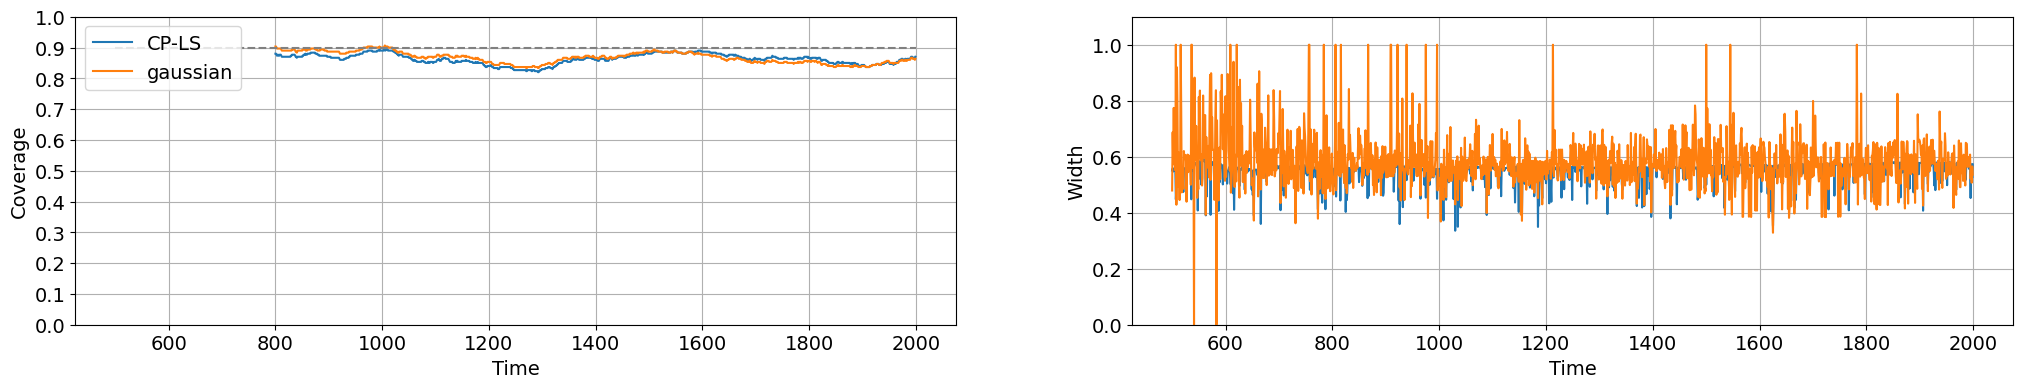

In [ ]:
plt.rcParams.update({'font.size': 14})

window = 300 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x, np.ones(window)/window)[(window-1):-window]
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,4))

for method_idx, method in enumerate(methods):
    ax[0].plot(np.arange(train_lag+window,N), rolling_avg(coverage[method_idx], window))
    ax[1].plot(np.arange(train_lag, N), pi_width[method_idx])

ax[0].hlines(1-alpha, xmin=train_lag, xmax=N, linestyles='--', colors='gray')
ax[0].legend(['CP-LS','gaussian'])

ax[0].set_ylabel('Coverage')
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[0].set_xlabel('Time')
ax[0].grid(True)

ax[1].set_ylabel('Width')
ymax = np.max([
    pi_width[method_idx].max() for method_idx in range(len(methods))
]) * 1.1
ax[1].set_ylim([0, ymax])
ax[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[1].set_xlabel('Time')
ax[1].grid(True)

plt.show()

In [ ]:
for method_idx, method in enumerate(methods):
    print(f'{method} coverage: {np.mean(coverage[method_idx])}')
    print(f'{method} average prediction interval width: {np.mean(pi_width[method_idx])}')
    print("-"*90)

CP+LS coverage: 0.8653333333333333
CP+LS average prediction interval width: 0.5484257239586096
------------------------------------------------------------------------------------------
gaussian coverage: 0.8713333333333333
gaussian average prediction interval width: 0.5828731156615029
------------------------------------------------------------------------------------------
